# Persistence Images in Classification

This is adapted from the demonstration available at https://github.com/scikit-tda/persim. In particular, I added more parameters to the experiment and more explanation for everything.

This notebook shows how you can use persistent homology and persistence images to classify datasets.  We construct datasets from two classes, one just noise and the other noise with a big circle in the middle. We then compute persistence diagrams with [Ripser.py](https://github.com/scikit-tda/ripser.py) and convert them to persistence images with [PersIm](https://github.com/scikit-tda/persim). Using these persistence images, we build a Logistic Regression model using a LASSO penatly to classify whether the dataset has a circle or not.  We find, using only default values, classification has a mean accuracy greater than 90.

In [1]:
# Import standard packages for linear algebra and statistics
import numpy as np
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Import a package to time computations
import time

# Import specialized TDA packages
from ripser import Rips
from persim import PersImage

## Construct data

We will construct a data set consisting of several pointclouds which are just noise and several pointclouds which are noise on top of a noisy circle. The goal is to see whether tools from persistent homology can be used to classify the data into two categories. Searching for structure in a noisy signal is an important task in many imaging applications, e.g. https://en.wikipedia.org/wiki/Transmission_electron_cryomicroscopy.

We begin by defining a function which generates a noisy point cloud sampled from a sphere.

In [2]:
def sample_spherical(npoints, scale=1, ndim=2):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    vec = scale*np.transpose(vec)
    return vec

def noisy_sphere(npoints, scale=1, noiseLevel=0.3, offset = 0, ndim=2):
    data = sample_spherical(npoints,scale, ndim)+scale*noiseLevel*np.random.random((npoints,ndim)) + offset*np.ones(ndim)
    return data

# npoints = number of points sampled
# scale = radius of the sphere being sampled
# noiseLevel = how "noisy" the samples are
# offset = shifts the circle in the (1,1,...,1) direction

Let's test it to make sure it produces the desired output.

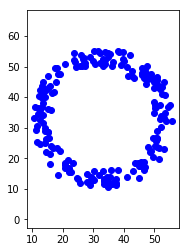

In [3]:
data = noisy_sphere(200, scale=20, offset=30)

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.plot(data[:, 0], data[:, 1], 'ob');
ax1.axis('equal');

Next we define a function which produces a noisy point cloud in space, with a given scale, in a given dimension.

In [4]:
def noise(N, scale, ndim=2):
    return scale * np.random.random((N, 2)) 

Now we construct our data set. There are lots of parameters to change to produce different experiments. In general we generate samples of random noise and samples of random noise with noisy circles embedded in them. We can change numbers of samples, how noisy everything is, size and location of the circles, etc.

In [5]:
# We first define a bunch of parameters for the experiment
total_samples = 200 # Number of samples in our experiment
samples_per_class = int(total_samples / 2) 
# Number of samples which are just noise. We will do our experiment taking an equal number each type of sample.
npoints = 400
# Number of points in each point cloud sample.
circle_noise_level = 0.4 # Noise level for the circles.
snr = 0.4
# Signal-to-noise ratio. For the images containing circles, this is the percentage of points that belong to the circle.
noise_scale = 150 # How large the noisy point cloud is
circle_scale = 30 # How large the noisy circle is. Should be chosen relative to the noise_scale.

# Generate the pure noise samples
just_noise = [noise(npoints, noise_scale) for _ in range(samples_per_class)]

# Generate the noise+circle samples
with_circle = [np.concatenate((noisy_sphere(int(snr*npoints), noiseLevel = circle_noise_level, scale=circle_scale, offset=(0.2*np.random.random()+0.4)*noise_scale), noise(npoints-int(snr*npoints), noise_scale)))
               for _ in range(samples_per_class)]

# Combine all the samples into one list.
datas = []
datas.extend(just_noise)
datas.extend(with_circle)

# Define labels. Pure noise samples are labeled with 0, noise+circles are labeled with 1.
# These labels will be used to train/test our classifyer.
labels = np.zeros(total_samples)
labels[samples_per_class:] = 1

Let's visualize the data. We'll plot a random pure noise sample and a random circle+noise sample.

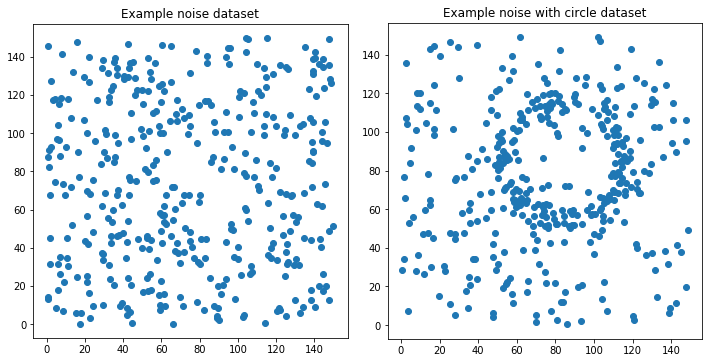

In [6]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10,5)

random_sample_choice = np.random.randint(100) # Pick a number between 0 and 100.

xs, ys = just_noise[random_sample_choice][:,0], just_noise[random_sample_choice][:,1]
axs[0].scatter(xs, ys)
axs[0].set_title("Example noise dataset")
axs[0].set_aspect('equal', 'box')

xs_, ys_ = with_circle[random_sample_choice][:,0], with_circle[random_sample_choice][:,1]
axs[1].scatter(xs_, ys_)
axs[1].set_title("Example noise with circle dataset")
axs[1].set_aspect('equal', 'box')

fig.tight_layout()

## Compute homology of each dataset

Generate the persistence diagram of $H_1$ for each of the datasets generated above.

In [7]:
start0 = time.time()
rips = Rips(maxdim=1, coeff=2); # Apply ripser with Z_2 coefficients, up to dimension 1.
diagrams = [rips.fit_transform(data) for data in datas]
diagrams_h1 = [rips.fit_transform(data)[1] for data in datas]
end0 = time.time()

print('Computation Time: ' + str(end0 - start0) + ' seconds')

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Computation Time: 49.3804550171 seconds


Let's plot persistence diagrams for a random choice of noise sample and a random choice of circle+noise. We'll use the "lifetime" plot style option because it will match will something we'll do with the diagrams later.

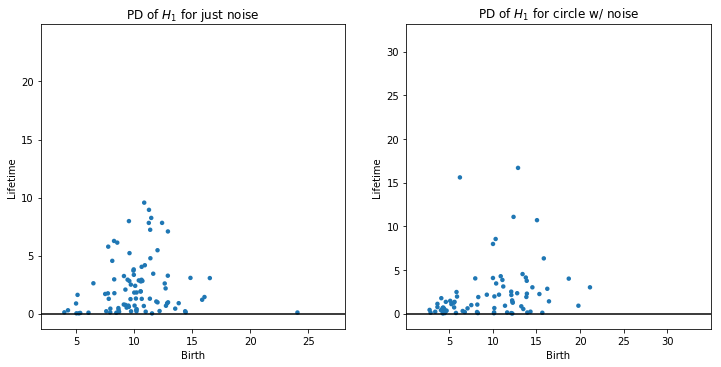

In [8]:
plt.figure(figsize=(12,6))
plt.subplot(121)

random_sample = np.random.randint(50)

rips.plot(diagrams_h1[random_sample], show=False, legend=False, lifetime=True)
plt.title("PD of $H_1$ for just noise")

plt.subplot(122)
rips.plot(diagrams_h1[-random_sample], show=False, legend=False, lifetime=True)
plt.title("PD of $H_1$ for circle w/ noise")

plt.show()

## Compute persistence images

Our goal is to do statistics on these persistence diagrams. Classical statistics is performed on vector spaces, but these PDs are not vectors! A popular approach to this problem is to find a way to construct a vector for each PD (so that the vectors live in the same vector space). The particular approach we will follow is to construct \emph{persistence images}, first introduced in this paper: https://arxiv.org/abs/1507.06217

We will discuss the definition of a persistence image in class. The 'persim' package is made to handle persistence images.

In [9]:
pim = PersImage(pixels=[20,20], spread=1)
imgs = pim.transform(diagrams_h1)

PersImage(pixels=[20, 20], spread=1, specs=None, kernel_type="gaussian", weighting_type="linear")


Let's take a look at the persistence images. We should interpret each image as the pixelated plot of a function $\mathbb{R}^2 \rightarrow \mathbb{R}$, with colors corresponding to height of the plot. Such a plot can be understood as a vector: by reshaping the 20-pixel-by-20-pixel image into a list of 400 numbers, we can think of it as a vector in $\mathbb{R}^{400}$.

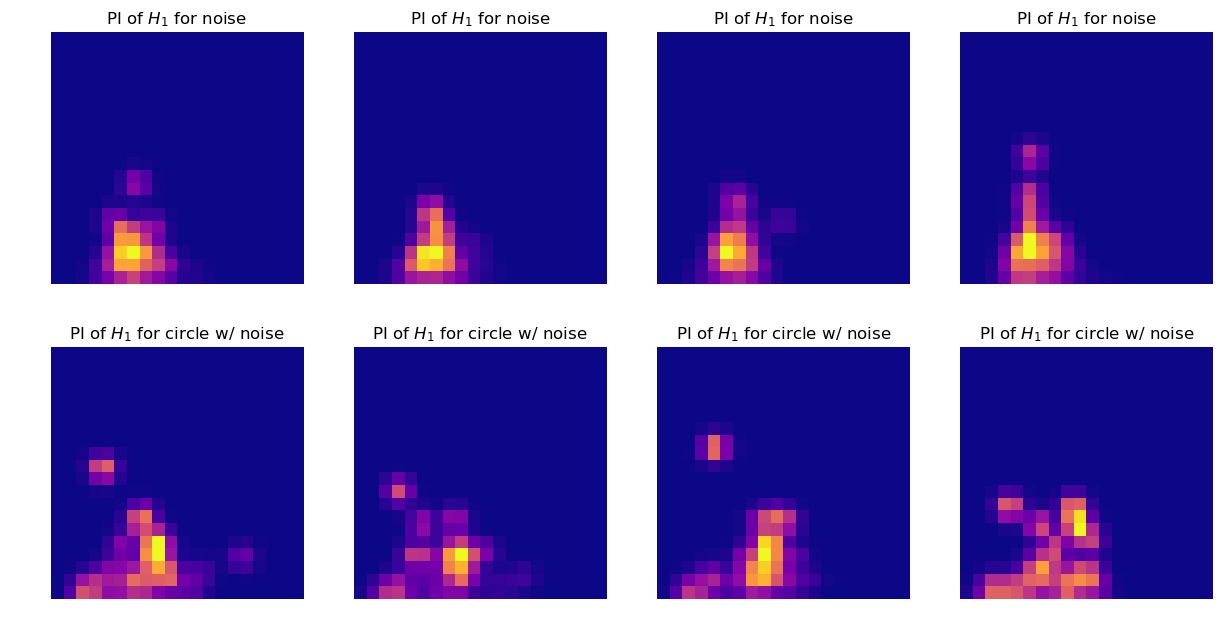

In [10]:
plt.figure(figsize=(15,7.5))

for i in range(4):
    ax = plt.subplot(240+i+1)
    pim.show(imgs[i], ax)
    plt.title("PI of $H_1$ for noise")

for i in range(4):
    ax = plt.subplot(240+i+5)
    pim.show(imgs[-(i+1)], ax)
    plt.title("PI of $H_1$ for circle w/ noise")

Roughly, these look like blurry plots of the persistence diagrams, with height corresponding roughly to density of points (technically, points farther from the $x$-axis are also given a higher "weight").

## Classify the datasets from the persistence images

So far we have the following pipeline: collection of datasets, organized into two categories --> collection of persistence diagrams --> collection of vectorized representations of these PDs. Now we can use classical statistical techniques to attempt to classify our data.

We first flatten each persistence image so that it is really represented as a vector in $\mathbb{R}^{400}$.

In [11]:
imgs_array = np.array([img.flatten() for img in imgs])

Next we randomly divide our data into a training set and a testing set (with labels for each).

In [12]:
X_train, X_test, y_train, y_test = train_test_split(imgs_array, labels, test_size=0.40, random_state=42)

Next we perform a logistic regression on the training data. Essentially, the goal of the logistic regression algorithm is to find a vector in $\mathbb{R}^{400}$ such that the label of each vector (persistence image) in the training set can be predicted by taking its dot product with the vector we find.

In [18]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Finally, we predict labels for the test data based off of the logistic regression. That is, we take the dot product with the vector we found by logistic regression and assign a label based on the result. We then check whether the predicted label agrees with the true label. We count the ratio of correct labels to get the LR score for the test data.

In [14]:
lr.score(X_test, y_test)

0.9875

We see that our predictor performs (surprisingly, to me) quite well!

## Inverse analysis on LASSO 

We can visualize the special vector that was found in the logistic regression algorithm. It is a vector in $\mathbb{R}^3$, but we can reshape it into a 20-pixel-by-20-pixel array, so that it matches the form of the persistence images. This should give an idea of which features are most important in classification. In the resulting figure, pink=0, purple=negative and orange=positive.

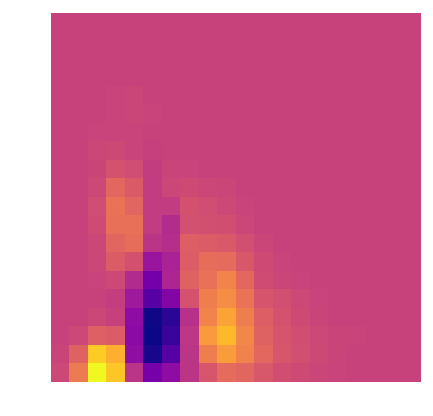

In [15]:
inverse_image = np.copy(lr.coef_).reshape((20,20))
pim.show(inverse_image)

## Sanity Check: A More Naive Approach

To test whether this excellent performance is a result of the efficacy of logistic regression, or the persistence image representation is actually useful, let's try to classify with a more naive approach.

Each sample in our data set is an npoints-by-2 array. We could flatten each of these to get a vector in $\mathbb{R}^{2 \cdot \mbox{npoints}}$, then run the same regression procedure to see if logistic regression can classify these vectors. 

(This is actually not so crazy! The way the noise+circle samples were constructed should give these $2\cdot \mbox{npoints}$-dimensional vectors a different structure than the pure noise samples.)

First we flatten the data, split into training and test sets and perform regression.

In [16]:
datas_array = np.array([sample.flatten() for sample in datas])

X_train, X_test, y_train, y_test = train_test_split(datas_array, labels, test_size=0.40, random_state=42)

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [20]:
datas_array.shape

(200, 800)

Then we test the regression score.

In [17]:
lr.score(X_test, y_test)

0.5875

We see that our regression does a little better than random guessing (at least if snr is not too low), but not nearly as well as the persistence images approach! 

Just for fun, let's take a look at the vector we are using to do the regression.

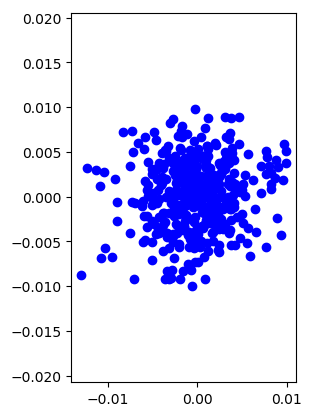

In [35]:
inverse_image = np.copy(lr.coef_).reshape((400,2))

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.plot(inverse_image[:, 0], inverse_image[:, 1],'ob')
ax1.axis('equal'); 